[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/contradiction_detection.ipynb)

# **JLNN – Contradiction Detection & Model Repair**

This notebook demonstrates a unique feature of JLNN: **the ability to detect and correct logical conflicts**. In classical neural networks, conflicting data leads to a *"blurred"* average, in JLNN it leads to an $L>U$ state, which can be explicitly identified and resolved.

## ***1. Theoretical Background: Logic Contradictions $(L>U)$***

In standard probability or fuzzy logic, truth is a single point. In **Logical Neural Networks (JLNN)**, truth is an interval $[L,U]$. This allows us to represent a state that is mathematically impossible in classical systems: **The Contradiction**.

#### ***What is a Contradiction?***

A contradiction occurs when the lower bound $L$ (what must be true) exceeds the upper bound U (what can be true):<br><br>

$$L>U \implies \text{Contradiction (Conflict)}$$


#### ***How JLNN Repairs Itself***

JLNN treats the consistency constraint $L \leq U$ as a differentiable objective. We use a **Contradiction Loss**:

$$\mathcal{L_{con}}​= \sum max(0,L−U)^2$$

During training, the optimizer adjusts weights and grounding parameters to minimize this conflict, while `apply_constraints(model)` ensures that weights stay in the valid logical domain $(w\geq1)$.

## ***2. INSTALLATION AND AUTOMATIC RESTART***

In Google Colab, you just need to install the package directly from GitHub. Since the export tools are built-in, no extra parameters are needed.

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 M

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

#### ***Library imports***

In [2]:
import jax.numpy as jnp
from flax import nnx
import optax
import matplotlib.pyplot as plt

from jlnn.symbolic.compiler import LNNFormula
from jlnn.nn.constraints import apply_constraints
from jlnn.training.losses import total_lnn_loss

## ***3. Creating a Contradictory Model***

We create a rule with a very high weight $(0.95)$ that says that if $A$ and $B$ are true, then $C$ must be true. But at the same time, we specify the inputs in such a way that the rule forces $C$ to high values, while we know that $C$ should be low.

#### Rule: If A and B, then C (with high importance 0.95)

In [3]:
model = LNNFormula("0.95::A & B -> C", nnx.Rngs(42))

#### Inputs where A and B are somewhat true, but we expect C to be false

In [4]:
inputs = {
    "A": jnp.array([[0.8, 0.9]]),
    "B": jnp.array([[0.7, 0.8]]),
    "C": jnp.array([[0.0, 0.2]]) # Target will conflict with the rule
}

### ***Initial inference***
#### We access the node directly to avoid the 'Tree' object issue

In [5]:
root_node = model.root.children[0] if hasattr(model.root, 'children') else model.root
initial_output = root_node.forward(inputs)

JAX returns array (batch, 2) or (batch, time, 2)<br>
We use .reshape(-1, 2) to be safe and take the zeroth (or last) element

In [6]:
flat_out = initial_output.reshape(-1, 2)

`.item()` safely converts a JAX scalar to a Python float

In [7]:
L_init = flat_out[0, 0].item()
U_init = flat_out[0, 1].item()

In [8]:
print(f"Initial C: [{L_init:.4f}, {U_init:.4f}]")
print(f"Contradiction detected: {L_init > U_init}")

Initial C: [0.5000, 0.7000]
Contradiction detected: False


## ***4. Visualization Function***

In [9]:
def plot_contradiction(L, U, title):
    fig, ax = plt.subplots(figsize=(8, 2))
    is_conflict = L > U
    color = 'salmon' if is_conflict else 'skyblue'

    # Plot the interval
    start = min(L, U)
    width = abs(U - L) if is_conflict else (U - L)

    ax.barh(['Truth Value'], [width], left=[start], color=color, height=0.5)
    ax.axvline(L, color='blue', linestyle='--', label=f'L={L:.2f}')
    ax.axvline(U, color='red', linestyle='--', label=f'U={U:.2f}')

    ax.set_xlim(-0.1, 1.1)
    ax.set_title(title)
    ax.legend(loc='lower right')
    if is_conflict:
        ax.text(0.5, 0.2, "CONTRADICTION (L > U)", color='red', fontweight='bold', ha='center')
    plt.show()

#### ***Visualization before training***

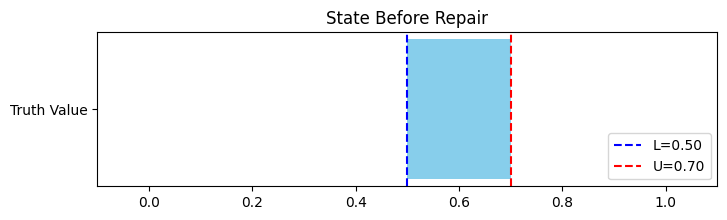

In [10]:
plot_contradiction(L_init, U_init, "State Before Repair")

## ***5. Training (Model Repair)***

We will use `total_lnn_loss`, which automatically penalizes inconsistency.<br>
We need to specify that we are optimizing with respect to `nnx.Param`

In [11]:
optimizer = nnx.Optimizer(
    model,
    optax.adam(0.02),
    wrt=nnx.Param  # <--- This is a key parameter
)

In [12]:
target = jnp.array([[0.0, 0.2]]) # Target interval for C (low true)

### ***Training function***

In [13]:
@nnx.jit
def train_step(model, optimizer, inputs, target):
    def loss_fn(m):
        # Forward pass skrze logický uzel
        node = m.root.children[0] if hasattr(m.root, 'children') else m.root
        pred = node.forward(inputs)
        # Using the total_lnn_loss function
        return total_lnn_loss(pred, target)

    # Calculate loss and gradients
    loss, grads = nnx.value_and_grad(loss_fn)(model)

    # FLAX 0.11+: update now requires both model and grads
    optimizer.update(model, grads)

    # Applying logical constraints (weights >= 1, L <= U)
    apply_constraints(model)

    return loss

### ***Trainig***

In [14]:
print("=== Repairing model consistency ===")
for step in range(101):
    current_loss = train_step(model, optimizer, inputs, target)
    if step % 20 == 0:
        print(f"Step {step:3d} | Loss: {current_loss:.6f}")

=== Repairing model consistency ===
Step   0 | Loss: 0.370000
Step  20 | Loss: 0.037225
Step  40 | Loss: 0.003284
Step  60 | Loss: 0.001161
Step  80 | Loss: 0.001009
Step 100 | Loss: 0.000942


### ***Final inference***

#### ***1. Získání syrového výstupu***

In [15]:
final_output = root_node.forward(inputs)

#### ***2. Reshape to (number_of_samples, 2) - this will get rid of the possible 'time' dimension***<br>
The result will be of the form $[N, 2]$, where N is the total number of intervals in the batch/time

In [16]:
flat_final = final_output.reshape(-1, 2)

#### ***3. Safe conversion to scalars using `.item()`***
Index $[0, 0]$ is the lower bound $(L)$, $[0, 1]$ is the upper bound $(U)$ of the first result

In [17]:
L_final = flat_final[0, 0].item()
U_final = flat_final[0, 1].item()

In [18]:
print(f"Fixed C: [{L_final:.4f}, {U_final:.4f}]")
print(f"Logical conflict removed? {L_final <= U_final}")

Fixed C: [0.0000, 0.1608]
Logical conflict removed? True


### ***Visualization***

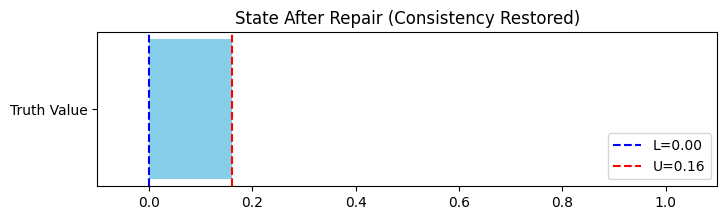

In [19]:
plot_contradiction(L_final, U_final, "State After Repair (Consistency Restored)")

## ***6. Summary***
- **Detection:** JLNN identified that the rule weights and input data are inconsistent $(L>U)$.
- **Fix:** Gradient descent adjusted the model parameters (weights and grounding) to minimize `contradiction_loss`.
- **Result:** The model is now logically consistent $(L≤U)$ and respects the training data.